In [6]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import statsmodels.api as sm

### Cleaning data

In [7]:
#data intake
df = pd.read_csv('Multiple-Linear-Dataset.csv')
df.head()

,Product_1,Product_2,Product_3,Location,Profit
0,165349.20,136897.80,471784.10,City_1,192261.83
1,162597.70,151377.59,443898.53,City_2,191792.06
2,153441.51,101145.55,407934.54,City_3,191050.39
3,144372.41,118671.85,383199.62,City_1,182901.99
4,142107.34,91391.77,366168.42,City_3,166187.94


In [8]:
#assigning variables
x = df[['Product_1','Product_2','Product_3','Location']]
y = df['Profit']
x.head()

,Product_1,Product_2,Product_3,Location
0,165349.20,136897.80,471784.10,City_1
1,162597.70,151377.59,443898.53,City_2
2,153441.51,101145.55,407934.54,City_3
3,144372.41,118671.85,383199.62,City_1
4,142107.34,91391.77,366168.42,City_3


In [9]:
#encoding location to account for category
print(df.Location.unique())

#using one hot encoder as these are true categorical variables
ohe = OneHotEncoder(sparse_output=False, drop='first')
location_encoded = ohe.fit_transform(x[['Location']])
location_cols = ohe.get_feature_names_out(['Location'])
location_df = pd.DataFrame(location_encoded, columns=location_cols)
#after creating a location df, using city_1 as the baseline we concatenate the Location df back to the original x variable df
x = pd.concat([x,location_df], axis=1)

#droping the original Location column
x = x.drop('Location', axis=1)
x.head()

['City_1' 'City_2' 'City_3']


,Product_1,Product_2,Product_3,Location_City_2,Location_City_3
0,165349.20,136897.80,471784.10,0.0,0.0
1,162597.70,151377.59,443898.53,1.0,0.0
2,153441.51,101145.55,407934.54,0.0,1.0
3,144372.41,118671.85,383199.62,0.0,0.0
4,142107.34,91391.77,366168.42,0.0,1.0


In [10]:
#creating the test, train split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=0)
print(x_train.head(1))
print(y_train.head(1))

    Product_1  Product_2  Product_3  Location_City_2  Location_City_3
33   55493.95  103057.49  214634.81              0.0              1.0
33    96778.92
Name: Profit, dtype: float64


### Visualizing predictors for exploration

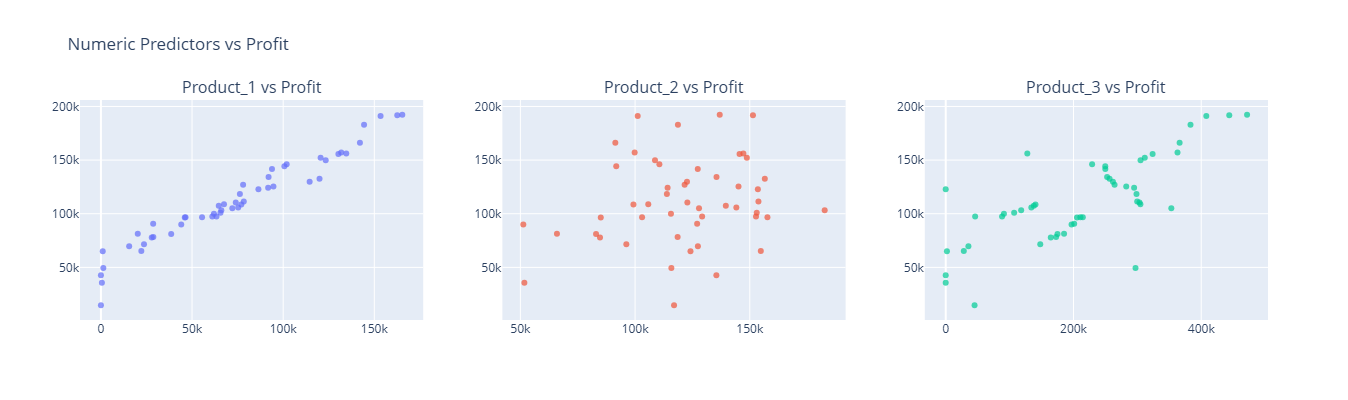

In [11]:
# scatter plots for continuous variables checking for heteroscedasticity. 
numeric_cols = ["Product_1", "Product_2", "Product_3"]
dummy_cols = ["Location_City_2", "Location_City_3"]


fig = make_subplots(
    rows=1,
    cols=3,
    subplot_titles=[f"{col} vs Profit" for col in numeric_cols]
)

for i, col in enumerate(numeric_cols, start=1):
    fig.add_trace(
        go.Scatter(
            x=df[col],
            y=y,
            mode="markers",
            name=col,
            marker=dict(opacity=0.7)
        ),
        row=1,
        col=i
    )

fig.update_layout(
    title="Numeric Predictors vs Profit",
    height=400,
    showlegend=False
)

fig.show()

In [12]:
print('product 2 looks like a weak signal')

product 2 looks like a weak signal


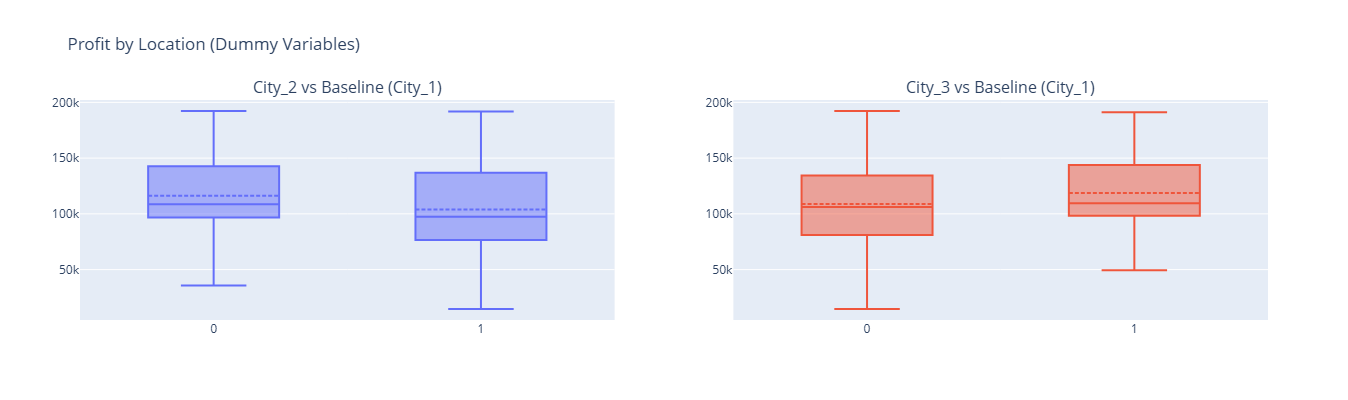

In [13]:
# Box plots for categorical variables
fig = make_subplots(
    rows=1,
    cols=2,
    subplot_titles=[
        "City_2 vs Baseline (City_1)",
        "City_3 vs Baseline (City_1)"
    ]
)

fig.add_trace(
    go.Box(
        x=x["Location_City_2"],
        y=y,
        name="City_2",
        boxmean=True
    ),
    row=1,
    col=1
)

fig.add_trace(
    go.Box(
        x=x["Location_City_3"],
        y=y,
        name="City_3",
        boxmean=True
    ),
    row=1,
    col=2
)

fig.update_layout(
    title="Profit by Location (Dummy Variables)",
    height=400,
    showlegend=False
)

fig.show()


In [14]:
x.corr()

,Product_1,Product_2,Product_3,Location_City_2,Location_City_3
Product_1,1.000000,0.241955,0.724248,-0.143165,0.105711
Product_2,0.241955,1.000000,-0.032154,-0.015478,0.010493
Product_3,0.724248,-0.032154,1.000000,-0.168875,0.205685
Location_City_2,-0.143165,-0.015478,-0.168875,1.000000,-0.492366
Location_City_3,0.105711,0.010493,0.205685,-0.492366,1.000000


### Model creation

In [15]:
#fitting regression to training set
regression = LinearRegression().fit(x_train,y_train)

In [16]:
#inspecting coefficients
coeffs = pd.Series(regression.coef_, index=x.columns)
coeffs

Product_1             0.773467
Product_2             0.032885
Product_3             0.036610
Location_City_2    -699.369053
Location_City_3   -1658.653213
dtype: float64

### Model evaluation using statsmodels and scikit

In [17]:
#prediciting salaries on test set
y_pred = regression.predict(x_test)

#understanding years of experience explainability
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))

print('R squared = ',r2)
print('RMSE = ',rmse)

R squared =  0.9347068473294996
RMSE =  9137.990152706976


In [18]:
x_sm = sm.add_constant(x)   # adds intercept
model = sm.OLS(y, x_sm).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     169.9
Date:                Thu, 22 Jan 2026   Prob (F-statistic):           1.34e-27
Time:                        10:01:48   Log-Likelihood:                -525.38
No. Observations:                  50   AIC:                             1063.
Df Residuals:                      44   BIC:                             1074.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            5.008e+04   6952.587      7.204      0.000    3.61e+04    6.41e+04
Product_1           0.8060      0.046     17.369      0.000       0.712       0.900
Product_2          -0.0270      0.052     -0.517      0.608      -0.132       0.078
Product_3           0.0270      0.017      1.574      0.123      -0.008       0.062
Location_City_2    41.8870   3256.039      0.013      0.990   -6520.229    6604.003
Location_City_3   240.6758   3338.857      0.072      0.943   -6488.349    6969.701
==============================================================================
Omnibus:                       14.782   Durbin-Watson:                   1.283
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.266
Skew:                          -0.948   Prob(JB):                     2.41e-05
Kurtosis:                       5.572   Cond. No.                     1.47e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
print('R squared is around 94 ~ 95% of explanation, already very high so no much iteration required.')

R squared is around 94 ~ 95% of explanation, already very high so no much iteration required.


### Model Iteration

In [28]:
# removing product two and running again
x_2 = x.drop('Product_2', axis=1)
x_2.head()


#creating the test, train split
x_train, x_test, y_train, y_test = train_test_split(x_2, y, test_size=.2, random_state=0)
print(x_train.head(1))
print(y_train.head(1))

#fitting regression to training set
regression = LinearRegression().fit(x_train,y_train)

#inspecting coefficients
coeffs = pd.Series(regression.coef_, index=x_2.columns)
coeffs


#prediciting salaries on test set
y_pred = regression.predict(x_test)

#understanding years of experience explainability
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test,y_pred))

print('R squared = ',r2)
print('RMSE = ',rmse)


## checking p_values again using statsmodels
x_sm = sm.add_constant(x_2)   # adds intercept
model = sm.OLS(y, x_sm).fit()
model.summary()

    Product_1  Product_3  Location_City_2  Location_City_3
33   55493.95  214634.81              0.0              1.0
33    96778.92
Name: Profit, dtype: float64
R squared =  0.9446968769427838
RMSE =  8409.916714491808


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     215.8
Date:                Thu, 22 Jan 2026   Prob (F-statistic):           9.72e-29
Time:                        10:05:42   Log-Likelihood:                -525.53
No. Observations:                  50   AIC:                             1061.
Df Residuals:                      45   BIC:                             1071.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            4.694e+04   3342.591     14.043      0.000    4.02e+04    5.37e+04
Product_1           0.7967      0.042     18.771      0.000       0.711       0.882
Product_3           0.0298      0.016      1.842      0.072      -0.003       0.062
Location_City_2    19.5234   3229.138      0.006      0.995   -6484.294    6523.340
Location_City_3   160.3104   3307.973      0.048      0.962   -6502.290    6822.910
==============================================================================
Omnibus:                       14.640   Durbin-Watson:                   1.257
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.037
Skew:                          -0.938   Prob(JB):                     2.70e-05
Kurtosis:                       5.565   Cond. No.                     8.90e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.9e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Conclusion 

In [32]:
print("The r squared explaination of fit was quite high and we can say with confidence that for every dollar of product 1 that is sold, profit increases $.71. As well, for every dollar of product 2 that is sold, profit increases $.03 cents. Although product 3 significance level is on the border between traditional 95%, in most businesses this would be a green light.")

The r squared explaination of fit was quite high and we can say with confidence that for every dollar of product 1 that is sold, profit increases $.71. As well, for every dollar of product 2 that is sold, profit increases $.03 cents. Although product 3 significance level is on the border between traditional 95%, in most businesses this would be a green light.
